<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cyto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running super-generalist "cyto3" model from cellpose3 in colab with a GPU

<font size = 4>Cellpose3 now allows you to restore and segment noisy/blurry/low res images!

For more details on Cellpose3 check out the [paper](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

Mount your google drive to access all your image files. This also ensures that the segmentations are saved to your google drive. 

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

## Images

Load in your own data or use ours (below)

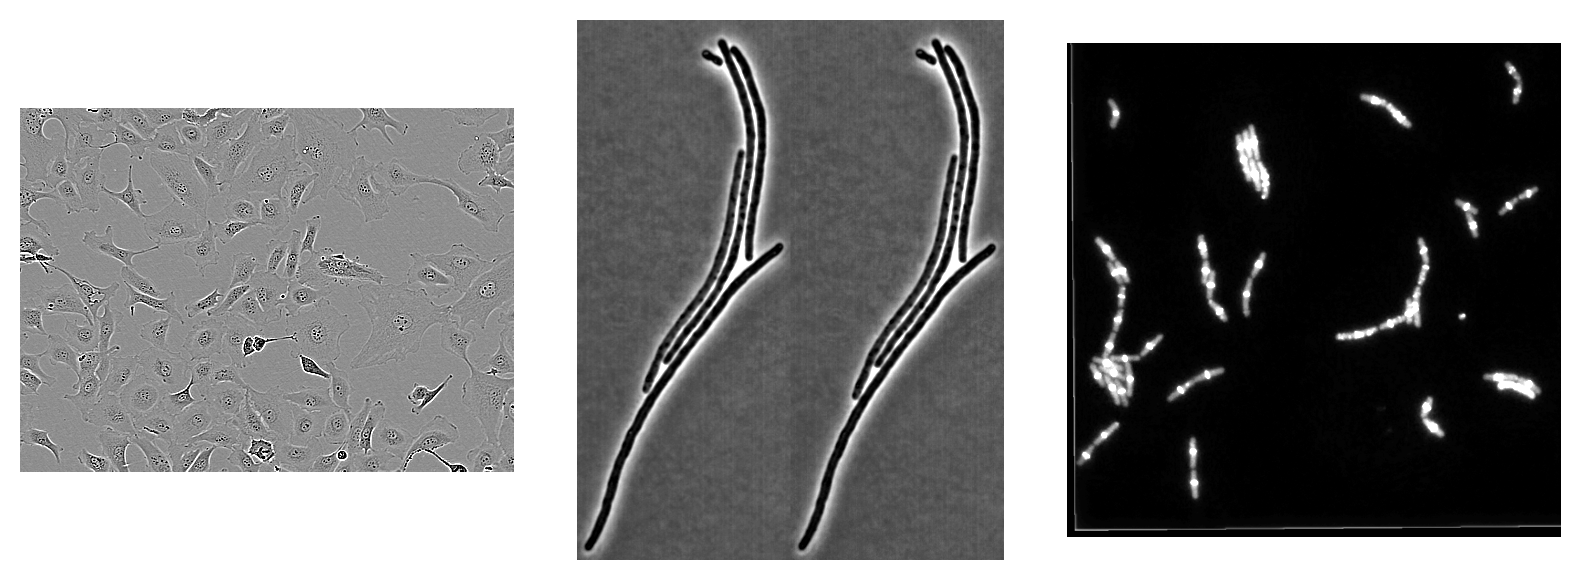

In [21]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
from cellpose import utils, io

# download noisy images from website
url = "http://www.cellpose.org/static/data/imgs_cyto3.npz"
filename = "imgs_cyto3.npz"
#utils.download_url_to_file(url, filename)
dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["imgs"] 
masks_true = dat["masks_true"] 

plt.figure(figsize=(8,3))
for i, iex in enumerate([9, 16, 21]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img[0], cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

Mount your google drive here if you want to load your own images:

In [ ]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')


## run segmentation

In [13]:
from cellpose import io

io.logger_setup() # run this to get printing of progress

# DEFINE CELLPOSE MODEL WITH SIZE
# model_type='cyto3' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type="cyto3")

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
# OR if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# FOR A CUSTOM MODEL OR OTHER BUILT-IN MODEL:
# model = models.CellposeModel(gpu=True, model_type="livecell_cp3")

masks_pred, flows, styles, diams = model.eval(imgs, diameter=0, channels=[1,2],
                                              niter=2000) # using more iterations for bacteria


2024-02-23 17:46:28,856 [INFO] WRITING LOG OUTPUT TO /home/carsen/.cellpose/run.log
2024-02-23 17:46:28,858 [INFO] 
cellpose version: 	3.0.5.dev5+gfdd2b68 
platform:       	linux 
python version: 	3.9.18 
torch version:  	2.1.0+cu121
2024-02-23 17:46:28,861 [INFO] ** TORCH CUDA version installed and working. **
2024-02-23 17:46:28,862 [INFO] >>>> using GPU
2024-02-23 17:46:28,863 [INFO] >> cyto3 << model set to be used
2024-02-23 17:46:28,992 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-02-23 17:46:28,996 [INFO] channels set to [1, 2]
2024-02-23 17:46:28,997 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-02-23 17:46:28,999 [INFO] 0%|          | 0/24 [00:00<?, ?it/s]


/media/carsen/ssd1/github/cellpose/cellpose/transforms.py:575: UserWarning: 'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0
  warnings.warn(


2024-02-23 17:46:41,215 [INFO] 100%|##########| 24/24 [00:12<00:00,  1.96it/s]
2024-02-23 17:46:41,217 [INFO] estimated cell diameter(s) in 12.22 sec
2024-02-23 17:46:41,218 [INFO] >>> diameter(s) = 
2024-02-23 17:46:41,219 [INFO] [29.08, 48.09, 51.68, 33.01, 21.11, 22.96, 13.01, 23.83, 17.00, 46.39, 38.81, 25.70, 41.52, 36.48, 42.17, 19.92, 52.93, 15.72, 52.29, 15.43, 15.88, 25.41, 29.08, 13.11, ]
2024-02-23 17:46:41,220 [INFO] ~~~ FINDING MASKS ~~~
2024-02-23 17:46:51,454 [INFO] 100%|##########| 24/24 [00:10<00:00,  2.35it/s]
2024-02-23 17:46:51,457 [INFO] >>>> TOTAL TIME 22.46 sec


plot results

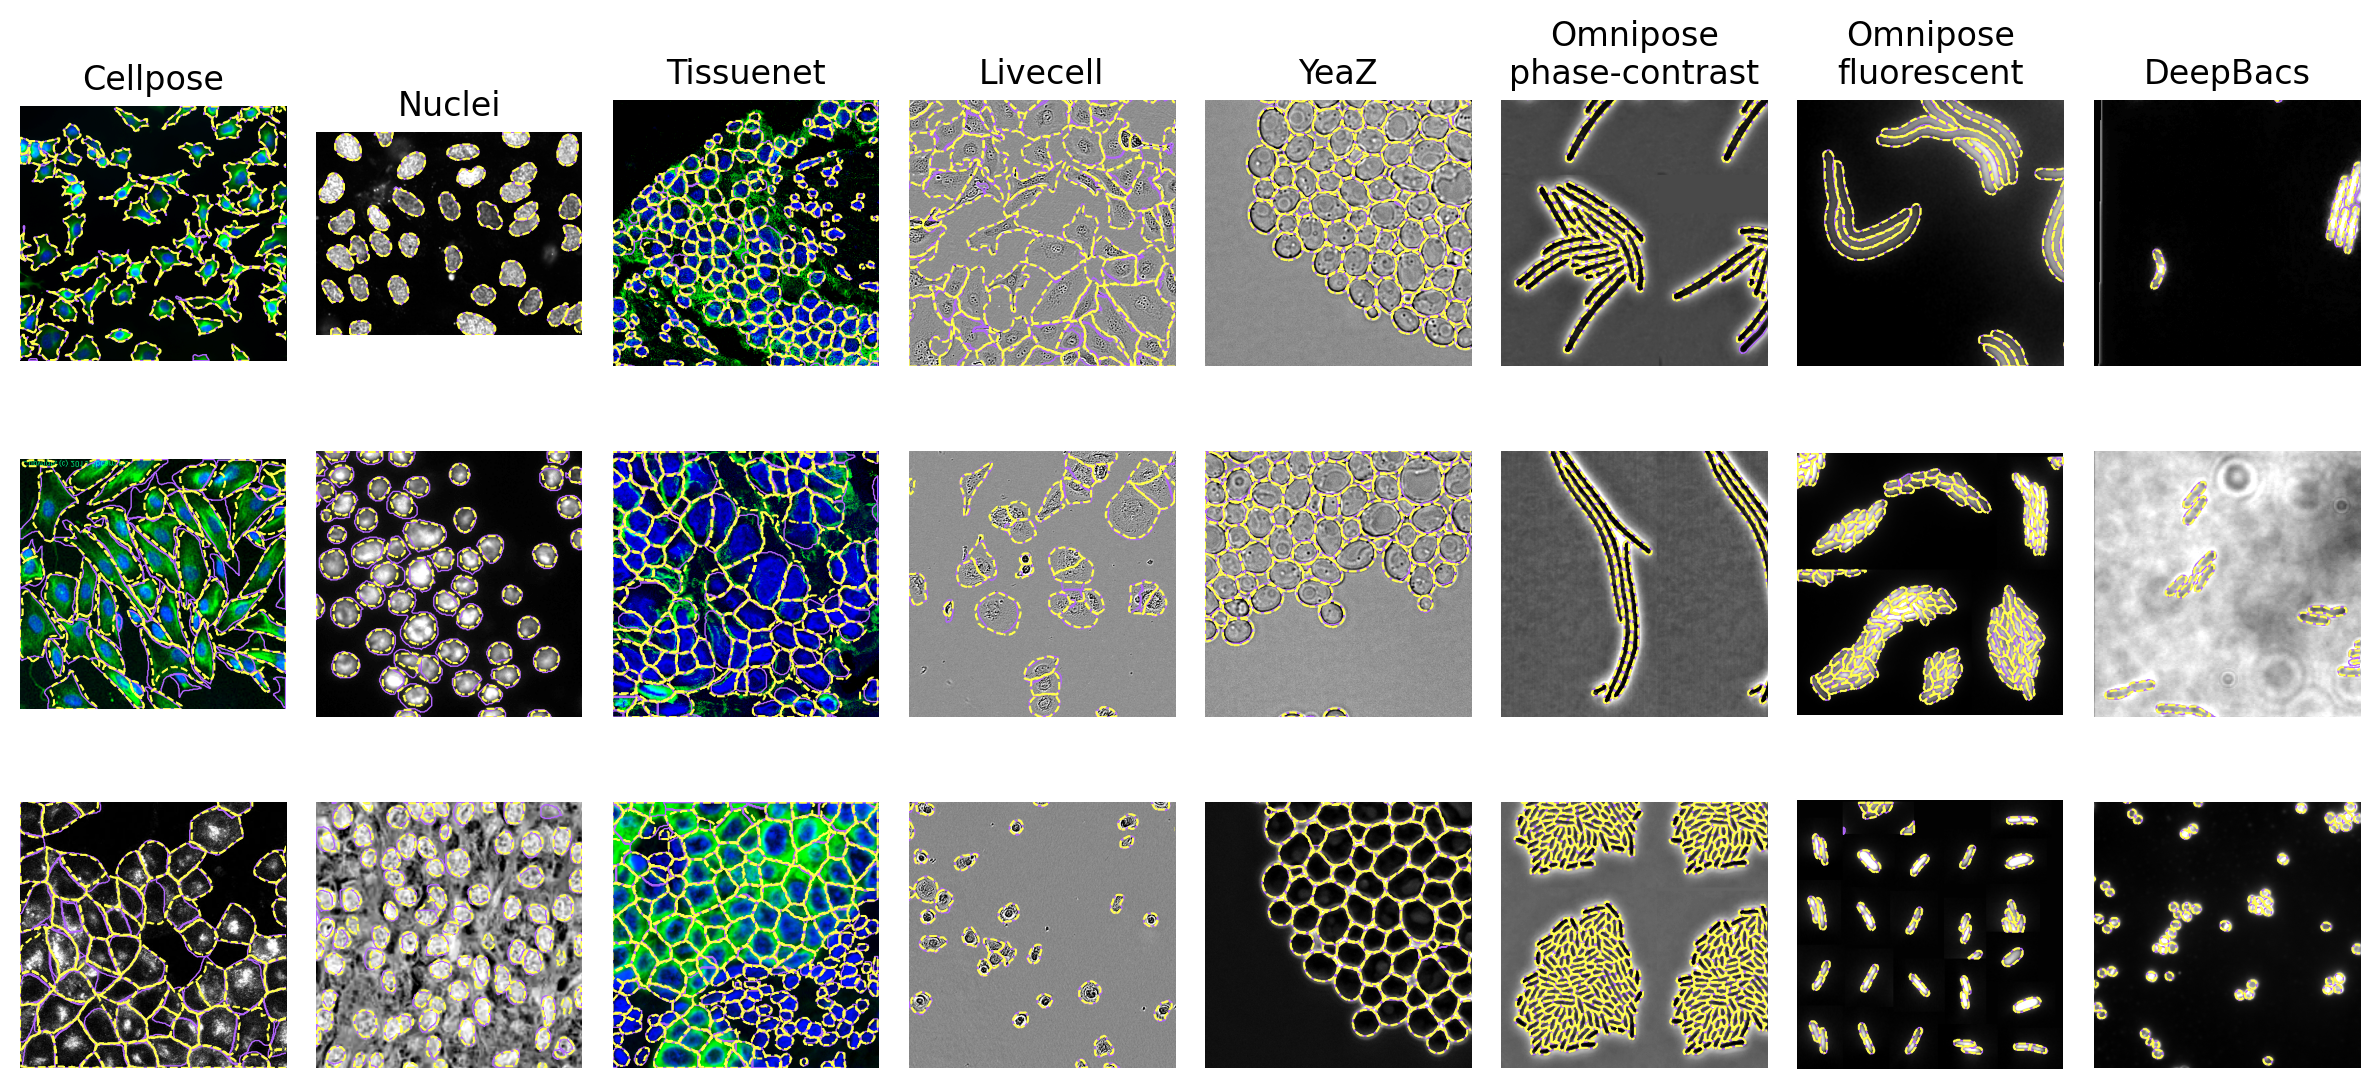

In [27]:
from cellpose import transforms, plot

titles = [
        "Cellpose", "Nuclei", "Tissuenet", "Livecell", "YeaZ",
         "Omnipose\nphase-contrast", "Omnipose\nfluorescent",
        "DeepBacs"
    ]

plt.figure(figsize=(12,6))
ly = 400
for iex in range(len(imgs)):
    img = imgs[iex].squeeze().copy()
    img = np.clip(transforms.normalize_img(img, axis=0), 0, 1) # normalize images across channel axis
    ax = plt.subplot(3, 8, (iex%3)*8 + (iex//3) +1)
    if img[1].sum()==0:
        img = img[0]
        ax.imshow(img, cmap="gray")
    else:
        # make RGB from 2 channel image
        img = np.concatenate((np.zeros_like(img)[:1], img), axis=0).transpose(1,2,0)
        ax.imshow(img)
    ax.set_ylim([0, min(400, img.shape[0])])
    ax.set_xlim([0, min(400, img.shape[1])])

    outlines_gt = utils.outlines_list(masks_true[iex])
    outlines_pred = utils.outlines_list(masks_pred[iex])
    for o in outlines_gt:
        plt.plot(o[:,0], o[:,1], color=[0.7,0.4,1], lw=0.5)
    for o in outlines_pred:
        plt.plot(o[:,0], o[:,1], color=[1,1,0.3], lw=0.75, ls="--")
    plt.axis('off')

    if iex%3 == 0:
        ax.set_title(titles[iex//3])
    
plt.tight_layout()
plt.show()